In [1]:
# testing the new automatic crl data trimmer function
import os
os.chdir( '/Users/etmu9498/research/code/scripts/save-new-datasets/')
import save_crl_data

save_crl_data.save_all_crl(tcname='all', shift_crl_dist=False, add_dist_coords=True)

Please select either 'crl' or 'in-situ' as a valid input forthe 'return' parameter in the find_crl_dist_in_situ() function.


In [3]:
# test new crl data
import xarray as xr
os.chdir('/Users/etmu9498/research/data/crl-new/' )
crl_data = xr.open_dataset( 'crl-grace-08-18-eye-1.nc')
crl_data


<xarray.Dataset>
Dimensions:             (Time: 2100, layers: 594, tdr_distance: 2099,
                         in_situ_distance: 2100, height: 2100, time: 594,
                         Lon: 2100, Lat: 2100)
Coordinates:
    time                (Time) float32 ...
    H                   (layers) float32 ...
  * tdr_distance        (tdr_distance) float64 -307.1 -306.8 ... 221.2 221.5
  * in_situ_distance    (in_situ_distance) float64 -286.6 -286.4 ... 240.9 241.1
  * Lon                 (Lon) float32 -85.11 -85.11 -85.11 ... -82.81 -82.81
  * Lat                 (Lat) float32 22.0 22.0 22.0 21.99 ... 18.2 18.2 18.2
Dimensions without coordinates: Time, layers, height
Data variables:
    ProductionDateTime  |S24 ...
    VersionID           int16 ...
    LSR                 (height, time) float32 ...
    WVMR                (height, time) float32 ...
    T                   (height, time) float32 ...
    P_ch1               (height, time) float32 ...
Attributes:
    global_att:    This file is generated with our Compact Raman lidar measur...
    global_att1:   The data for each flight is mapped to the same height bin ...
    global_att2:  For Question about this product, contact Zhien Wang, 
    global_att3:   University of Colorado, Boulder at zhien.wang@colorado.edu
    global_att4:  This Dataset is a subset of the full CRL dataset for 08-18-...

In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import warnings
import datetime

os.chdir(  "/Users/etmu9498/research/code/scripts")
import tc_metadata
import make_plots
import helper_fns

In [6]:
# get metadata for a specific tc example 
tcname = 'sam'
dataset = 2
metadata = tc_metadata.all_data( tc= tcname)

crl_name = tc_metadata.choose_crl_date( metadata[ 'dates'][ dataset], metadata[ 'crl_list'])
in_situ_name = tc_metadata.choose_in_situ_date( metadata[ 'dates'][ dataset], metadata[ 'in_situ_list'])
inbound_name, outbound_name = tc_metadata.choose_tdr_data( tcname, metadata[ 'tdr_list'], dataset)
print( metadata)

{'crl_path': '/Users/etmu9498/research/data/CRL_data/2021', 'tdr_path': '/Users/etmu9498/research/data/tdr/sam/nc-files', 'in_situ_path': '/Users/etmu9498/research/data/in-situ', 'crl_list': ['P3_20210811H1_200000-224759.cdf', 'P3_20210812H1_095513-125927.cdf', 'P3_20210812H2_212248-235510.cdf', 'P3_20210813H1_091801-113558.cdf', 'P3_20210816H1_085245-123459.cdf', 'P3_20210816H1_090000-102359.cdf', 'P3_20210817H1_094204-132058.cdf', 'P3_20210818H1_211425-244159.cdf', 'P3_20210819H1_213003-244159.cdf', 'P3_20210820H1_212402-245958.cdf', 'P3_20210821H2_213903-225658.cdf', 'P3_20210821H2_213903-262058.cdf', 'P3_20210827H1_203112-275220.cdf', 'P3_20210828H1_200115-221321.cdf', 'P3_20210829H1_171201-223719.cdf', 'P3_20210925H1_211201-243558.cdf', 'P3_20210926H1_220900-255058.cdf', 'P3_20210927H1_213003-253558.cdf', 'P3_20210929H2_211201-261159.cdf'], 'tdr_list': ['210926H1_2237_vert_inbound.nc', '210926H1_2237_vert_outbound.nc', '210926H1_2350_vert_inbound.nc', '210926H1_2350_vert_outbound.

In [7]:
# load crl data
os.chdir( metadata[ 'crl_path'])
crl_data = xr.open_dataset( crl_name)
print( crl_name)

# load tdr data
os.chdir( metadata['tdr_path'])
inbound_data = xr.open_dataset( inbound_name)
outbound_data = xr.open_dataset( outbound_name)

crl_data

P3_20210926H1_220900-255058.cdf


<xarray.Dataset>
Dimensions:             (Time: 6649, layers: 594)
Dimensions without coordinates: Time, layers
Data variables:
    ProductionDateTime  |S24 ...
    VersionID           int16 ...
    Lon                 (Time) float32 ...
    Lat                 (Time) float32 ...
    H                   (layers) float32 ...
    time                (Time) float32 ...
    LSR                 (Time, layers) float32 ...
    WVMR                (Time, layers) float32 ...
    T                   (Time, layers) float32 ...
    P_ch1               (Time, layers) float32 ...
Attributes:
    global_att:    This file is generated with our Compact Raman lidar measur...
    global_att1:   The data for each flight is mapped to the same height bin ...
    global_att2:  For Question about this product, contact Zhien Wang, 
    global_att3:   University of Colorado, Boulder at zhien.wang@colorado.edu

In [4]:
# clear out the data array to prepare for adding new variables
crl_new = crl_data.copy() 
crl_new = crl_new[ ['ProductionDateTime', 'VersionID']] 
# add a new attribute explaining how this dataset has been edited
disclaimer = 'This Dataset is a subset of the full CRL dataset for ' + metadata['dates'][dataset] + '-2021. Please see the file ' + crl_name + ' for the full dataset.'
crl_new.attrs[ 'global_att4'] = disclaimer


# add time and height as coordinates, not variables!
cliptime = crl_data.time[ metadata['crl_range'][dataset][0] : metadata['crl_range'][dataset][1] ]
print( len( cliptime))
crl_new = crl_new.assign_coords( {'time': cliptime })
crl_new = crl_new.assign_coords( {'height': crl_data.H })

i1 = metadata[ 'crl_range'][dataset][0]
i2 = metadata[ 'crl_range'][dataset][1]

# loop through all the variables in crl_data, cropping them to the smaller i1 and i2 values provided
var_list = list( crl_data.keys() )
print( var_list)
for key_ind in range( len( var_list)):    
    # saving 2D arrays
    try:        
        # clip the data
        currentdata = crl_data[ var_list[ key_ind]]
        # dataclip = xr.DataArray.to_numpy( currentdata [ i1:i2, :] )
        dataclip = currentdata [ i1:i2].data # this snippet does the same thing as above
        # add data to the new, smaller xarray file
        crl_new = crl_new.assign( { var_list[ key_ind]: ( ('height', 'time'), dataclip) })
        
        # add all the attribute metadata to the new dataset!
        # get the old metadata
        attr_dict = crl_data[ var_list[ key_ind]].attrs
        # recursively add all keys to new dataset!
        for key2 in attr_dict:
            crl_new[ var_list[ key_ind]].attrs[ key2] = attr_dict[ key2]

    # not a 2D array:
    except (IndexError, ValueError): 
        continue

# add lat and lon manually because it's being a pain to do it automatically    
lonclip = crl_data.Lon[ i1:i2].data
crl_new = crl_new.assign_coords( { 'Lon':  lonclip })
latclip = crl_data.Lat[ i1:i2].data
crl_new = crl_new.assign_coords( { 'Lat':  latclip })

for key in ['Lon', 'Lat']:
    attr_dict = crl_data[ key].attrs
    # recursively add all keys to new dataset!
    for key2 in attr_dict:
        crl_new[ key].attrs[ key2] = attr_dict[ key2]

    
crl_new

1200
['ProductionDateTime', 'VersionID', 'Lon', 'Lat', 'H', 'time', 'LSR', 'WVMR', 'T', 'P_ch1']


<xarray.Dataset>
Dimensions:             (Time: 1200, layers: 594, height: 1200, time: 594,
                         Lon: 1200, Lat: 1200)
Coordinates:
    time                (Time) float32 24.6 24.6 24.6 24.6 ... 25.27 25.27 25.27
    height              (layers) float32 -3.589 -3.583 ... -0.0367 -0.0307
  * Lon                 (Lon) float32 -49.95 -49.95 -49.95 ... -51.72 -51.72
  * Lat                 (Lat) float32 13.23 13.23 13.23 ... 15.51 15.51 15.51
Dimensions without coordinates: Time, layers
Data variables:
    ProductionDateTime  |S24 b'2022-03-20T21:39:03.00 Z'
    VersionID           int16 0
    LSR                 (height, time) float32 0.01 0.01 0.01 ... 0.01 0.01 0.01
    WVMR                (height, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    T                   (height, time) float32 999.0 999.0 999.0 ... nan nan nan
    P_ch1               (height, time) float32 -0.2005 -0.2005 ... -3.563e-05
Attributes:
    global_att:    This file is generated with our Compact Raman lidar measur...
    global_att1:   The data for each flight is mapped to the same height bin ...
    global_att2:  For Question about this product, contact Zhien Wang, 
    global_att3:   University of Colorado, Boulder at zhien.wang@colorado.edu
    global_att4:  This Dataset is a subset of the full CRL dataset for 09-26-...

594
1200
1200
594


Text(0.5, 0, 'hi')

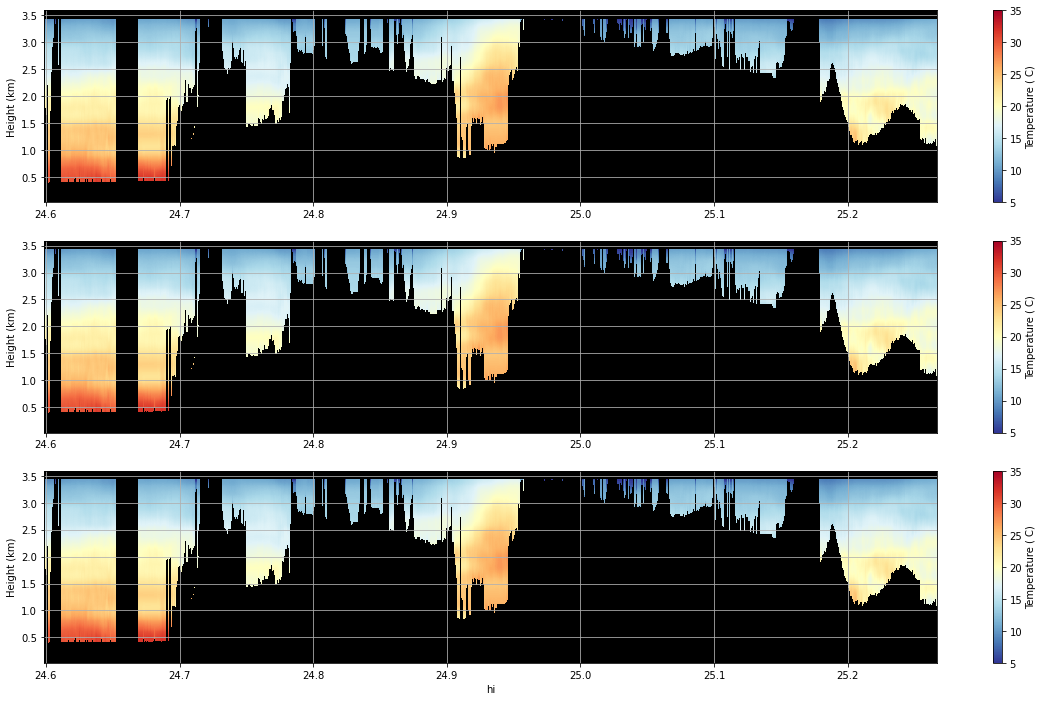

In [15]:
# it seems like there are slight differences between plotting the newly created crl file and through the old method...
# i'm trying to get to the bottom of that here

plt.clf()

print( len( crl_new.height))
print( len( crl_new.time))
print( np.size( crl_new.WVMR, 0))
print( np.size( crl_new.WVMR, 1))

plt.figure( figsize=(20, 12))
plt.subplot(311)

'''
temp = crl_new.T.where( crl_new.T.values < 50).transpose()

os.chdir( metadata[ 'crl_path'])
crl_copy = xr.open_dataset( crl_name)
old_temp = crl_copy.T[ metadata['crl_range'][dataset][0]: metadata['crl_range'][dataset][1], :] 
old_temp = old_temp.where( old_temp.values < 50).transpose()

temp = temp.to_numpy()
old_temp = old_temp.to_numpy()

difference = np.subtract( temp, old_temp)
# print( np.shape( old_temp))
# print( np.shape( temp))
'''

# plt.pcolormesh( crl_new.time, - crl_new.height, difference, cmap='bwr', vmin = -.005, vmax = .005) # plt.cm.get_cmap( "RdYlBu").reversed(), vmin=5, vmax=35)
# plt.pcolormesh( crl_new.time, - crl_new.height, old_temp, cmap=plt.cm.get_cmap( "RdYlBu").reversed(), vmin=5, vmax=35)
make_plots.plot_T( metadata[ 'crl_path'], crl_name, metadata['crl_range'][dataset][0], metadata['crl_range'][dataset][1], 'time')
# plt.colorbar()

# plt.grid('on')
# plt.title( 'New CRL Dataset')
# ax = plt.gca()
# ax.set_facecolor('k')

plt.subplot( 312)
make_plots.plot_T( metadata[ 'crl_path'], crl_name, metadata['crl_range'][dataset][0], metadata['crl_range'][dataset][1], 'time')

plt.subplot( 313)
make_plots.plot_T( metadata[ 'crl_path'], crl_name, metadata['crl_range'][dataset][0], metadata['crl_range'][dataset][1], 'time')
plt.xlabel( 'hi')

In [6]:
# save new crl file!
filename = 'crl-' + metadata[ 'tc_name'].lower() + '-' + metadata[ 'dates'][ dataset] + '-eye-' + metadata[ 'eye_pass'][ dataset] + '.nc'
print( filename)
crl_new.to_netcdf('/Users/etmu9498/research/data/crl-new/' + filename)

crl-sam-09-26-eye-3.nc


In [7]:
# check that the right file has been saved!
os.chdir( '/Users/etmu9498/research/data/crl-new')
crl_saved = xr.open_dataset( 'crl-sam-09-26-eye-3.nc')
crl_saved

<xarray.Dataset>
Dimensions:             (Time: 1200, layers: 594, height: 1200, time: 594,
                         Lon: 1200, Lat: 1200)
Coordinates:
    time                (Time) float32 ...
    height              (layers) float32 ...
  * Lon                 (Lon) float32 -49.95 -49.95 -49.95 ... -51.72 -51.72
  * Lat                 (Lat) float32 13.23 13.23 13.23 ... 15.51 15.51 15.51
Dimensions without coordinates: Time, layers
Data variables:
    ProductionDateTime  |S24 ...
    VersionID           int16 ...
    LSR                 (height, time) float32 ...
    WVMR                (height, time) float32 ...
    T                   (height, time) float32 ...
    P_ch1               (height, time) float32 ...
Attributes:
    global_att:    This file is generated with our Compact Raman lidar measur...
    global_att1:   The data for each flight is mapped to the same height bin ...
    global_att2:  For Question about this product, contact Zhien Wang, 
    global_att3:   University of Colorado, Boulder at zhien.wang@colorado.edu
    global_att4:  This Dataset is a subset of the full CRL dataset for 09-26-...

In [ ]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

In [18]:
# see how the data looks!
import os
import xarray as xr
import matplotlib.pyplot as plt

os.chdir( "/Users/etmu9498/research/data/crl-new")
crl_data = xr.open_dataset( 'crl-grace-08-18-eye-1.nc')
crl_data2 = xr.open_dataset( 'crl-sam-09-29-eye-1.nc')
crl_data3 = xr.open_dataset( 'crl-ida-08-29-eye-2.nc')
color_map = plt.cm.get_cmap( "RdYlBu").reversed()

crl_data3

<xarray.Dataset>
Dimensions:             (Time: 3200, layers: 594, height: 3200, time: 594,
                         Lon: 3200, Lat: 3200)
Coordinates:
    time                (Time) float32 ...
    height              (layers) float32 ...
  * Lon                 (Lon) float32 -86.61 -86.61 -86.62 ... -91.91 -91.91
  * Lat                 (Lat) float32 29.13 29.13 29.13 ... 27.98 27.98 27.98
Dimensions without coordinates: Time, layers
Data variables:
    ProductionDateTime  |S24 ...
    VersionID           int16 ...
    LSR                 (height, time) float32 ...
    WVMR                (height, time) float32 ...
    T                   (height, time) float32 ...
    P_ch1               (height, time) float32 ...
Attributes:
    global_att:    This file is generated with our Compact Raman lidar measur...
    global_att1:   The data for each flight is mapped to the same height bin ...
    global_att2:  For Question about this product, contact Zhien Wang, 
    global_att3:   University of Colorado, Boulder at zhien.wang@colorado.edu
    global_att4:  This Dataset is a subset of the full CRL dataset for 08-29-...

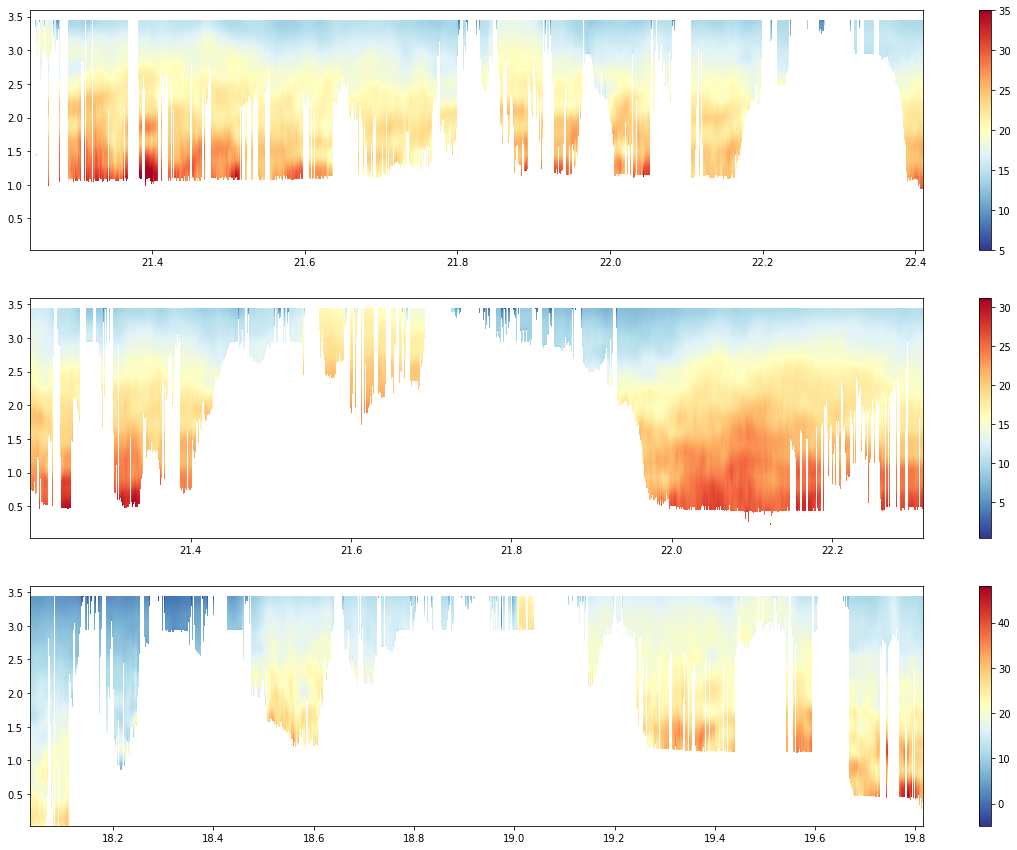

In [19]:
plt.figure( figsize=( 20, 15))
plt.subplot(311)

temp = crl_data.T 
temp = temp.where( temp.values < 50).transpose()
plt.pcolormesh( crl_data.time, - crl_data.height, temp, cmap=color_map, vmin=5, vmax=35)
plt.colorbar()

plt.subplot(312)
temp = crl_data2.T 
temp = temp.where( temp.values < 50).transpose()

plt.pcolormesh( crl_data2.time, - crl_data2.height, temp, cmap=color_map)
plt.colorbar()

plt.subplot(313)
temp = crl_data3.T 
temp = temp.where( temp.values < 50).transpose()

plt.pcolormesh( crl_data3.time, - crl_data3.height, temp, cmap=color_map)
plt.colorbar()